# Advanced Lane Finding

### Environment Setup

Load all of the submodules and global variable setup

In [1]:
%run utilities.ipynb

OUTPUT_DIR = 'output_images'

### I. Camera Calibration

First, Setup parameters for camera calibration.

In [2]:
%run calibration.ipynb

CALIBRATION_IMAGE_PATH = 'camera_cal'
# select four images for demonstration
IMAGE_FILTERS = ['calibration{}.jpg'.format(i) for i in [1, 2, 3, 5]] 

Second, load images and show the *original* images (four images are selected for illustration). 

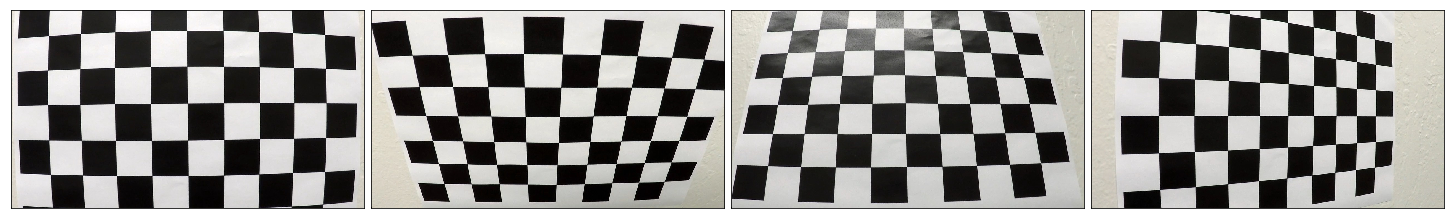

In [3]:
calibration_images = read_images(CALIBRATION_IMAGE_PATH)
save_selected_images(calibration_images, 
                     os.path.join(OUTPUT_DIR, "calib_original.jpg"), 
                     IMAGE_FILTERS)
#save_image(calibration_images['calibration2.jpg'], os.path.join(OUTPUT_DIR, 'calibration2.jpg'))

Third, calibrate camera and show the calibrated images. 

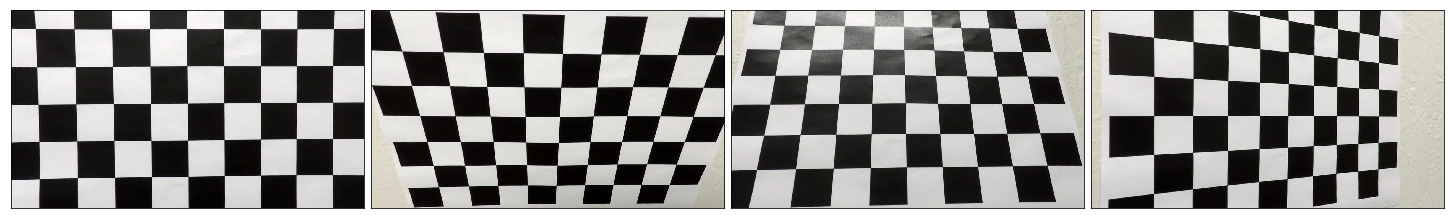

In [4]:
# mtx, camera matrix used for transforming object points in 3d to ones in 2d
# dist, distortion coefficient
_, mtx, dist, _, _ = calibrate()
recovered_images = undistort_all(calibration_images, mtx, dist)
save_selected_images(recovered_images, 
                     os.path.join(OUTPUT_DIR, 'calib_undistorted.jpg'),
                     IMAGE_FILTERS)
#save_image(recovered_images['calibration2.jpg'], os.path.join(OUTPUT_DIR, 'calibration2_undistorted.jpg'))

### II. Undistortion

First, check the original test images. 

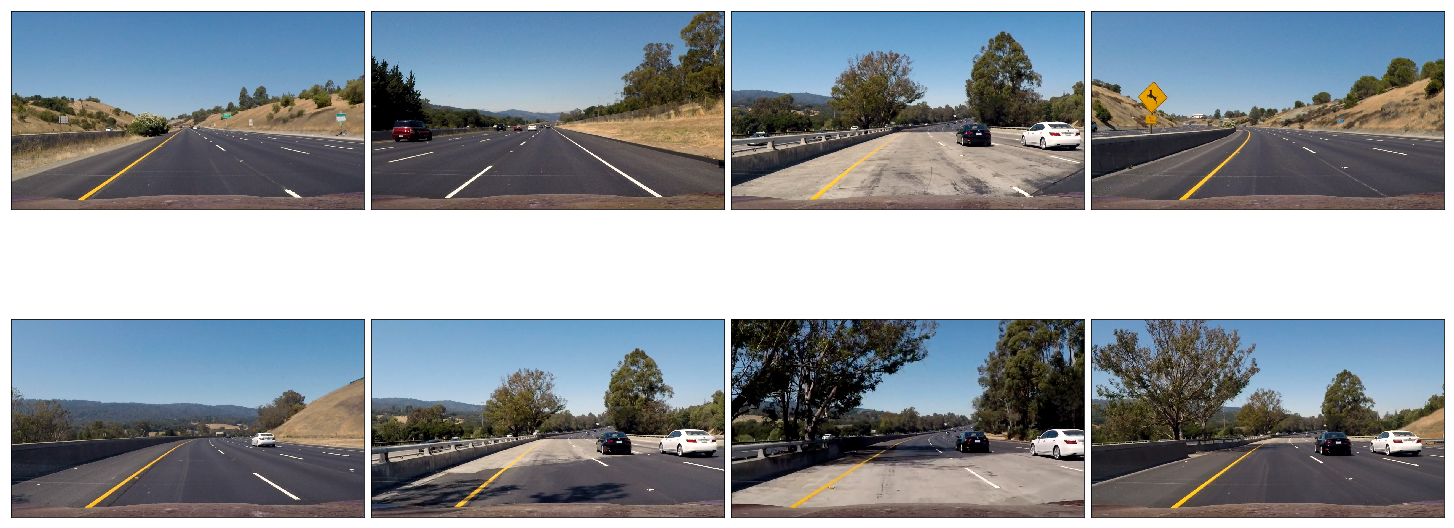

In [5]:
%run threshold_image.ipynb

TEST_IMAGE_DIRECTORY = 'test_images'
test_images = read_images(TEST_IMAGE_DIRECTORY)
save_images(test_images, os.path.join(OUTPUT_DIR, 'images_orig.jpg'))

Second, check the undistorted images. 

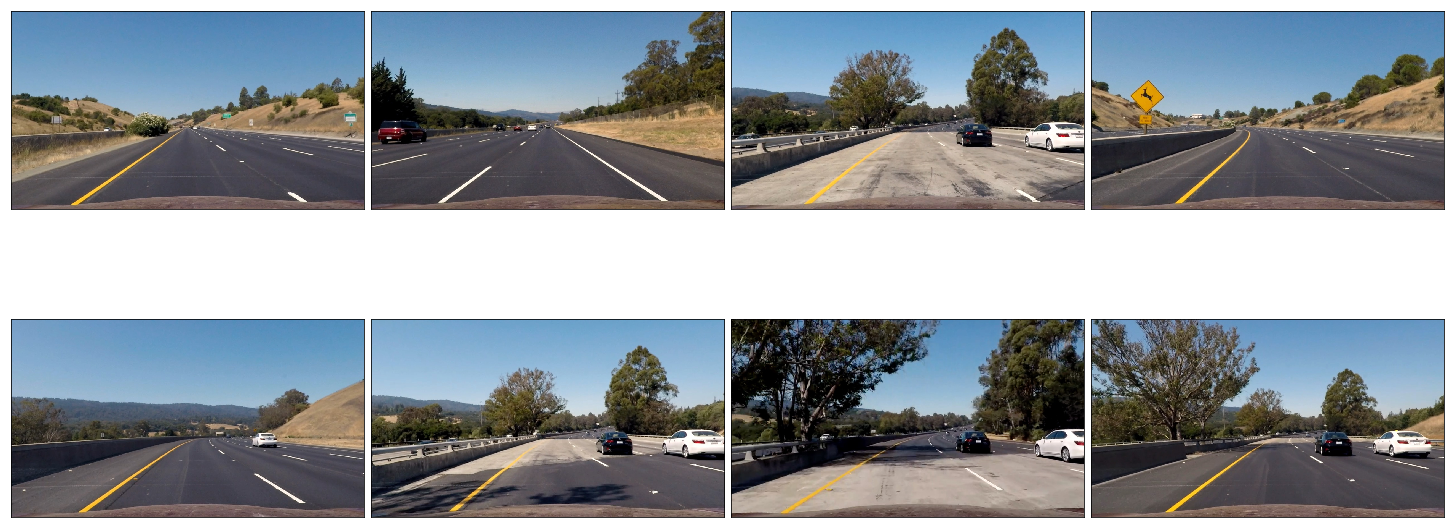

In [6]:
DEMO_IMG_NAME = 'straight_lines1.jpg'
undistorted_images = undistort_all(test_images, mtx, dist)
save_images(undistorted_images, os.path.join(OUTPUT_DIR, 'images_undistorted.jpg'))
#save_image(undistorted_images[DEMO_IMG_NAME], os.path.join(OUTPUT_DIR, 'demo_undistorted.jpg'))

### III. Threshold image

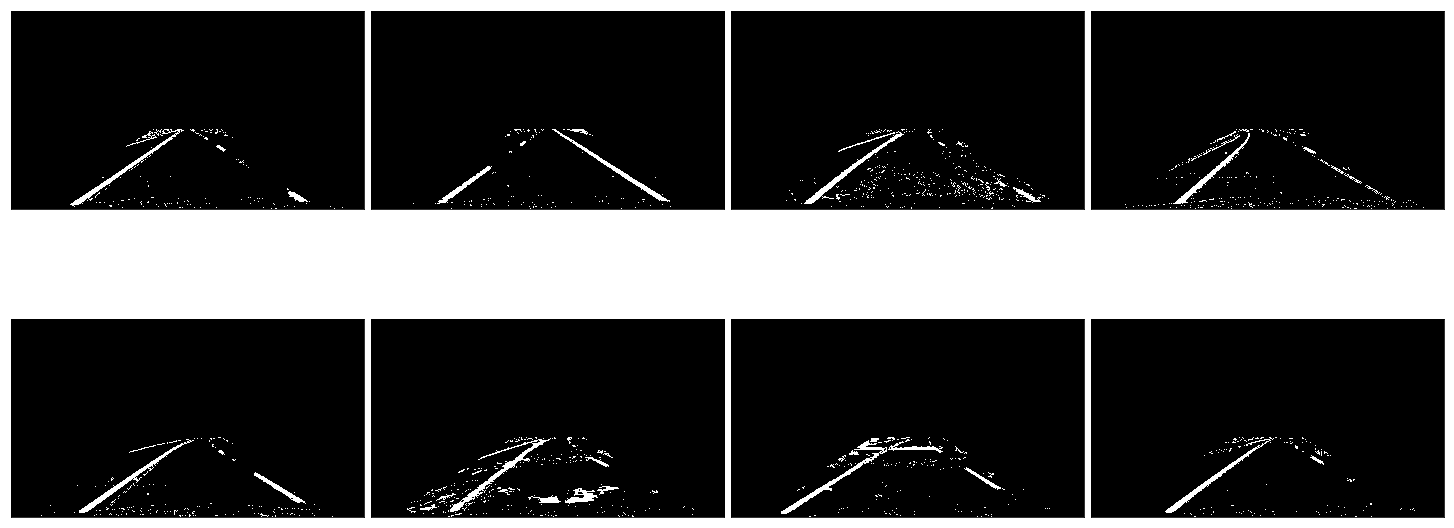

In [7]:
thresholded_images = {}
for fname, img in undistorted_images.items():
    thresholded_img = mix_threshold(img, True)
    thresholded_images[fname] = thresholded_img

save_images(thresholded_images, os.path.join(OUTPUT_DIR, 'images_threshold.jpg'))
#save_selected_images(thresholded_images, os.path.join(OUTPUT_DIR, 'demo_thresholded.jpg'), [DEMO_IMG_NAME])

### IV. Perspective Transform

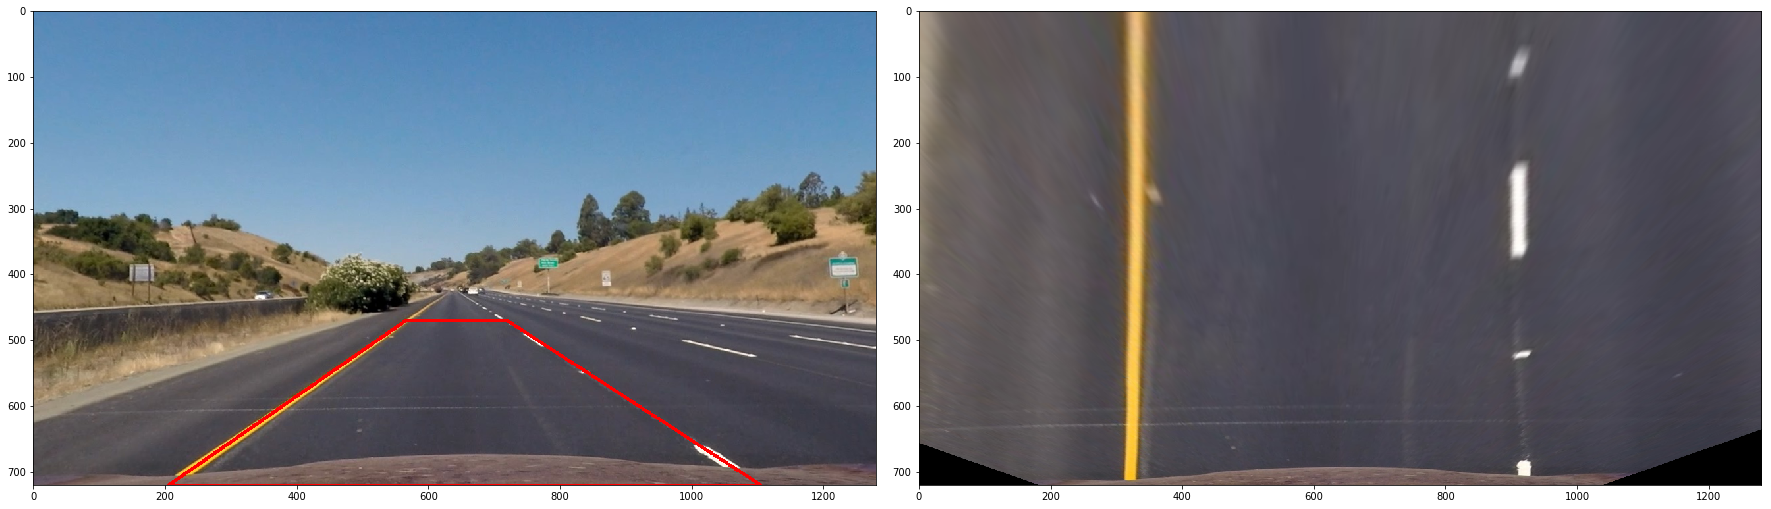

In [8]:
%run perspective_transform.ipynb

demo_image = undistorted_images[DEMO_IMG_NAME]
M, M_inv = get_perspective_transform(demo_image, True)

### V. Lane Line Pixel Detection

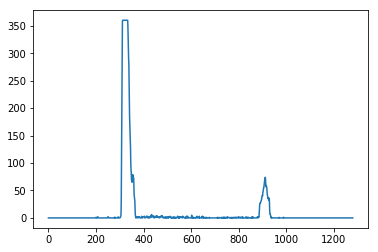

In [9]:
# load pipeline modules and set environment
%run lane_lines.ipynb
set_globals(M, M_inv, mtx, dist)

thresholded_img = mix_threshold(undistort_one(undistorted_images[DEMO_IMG_NAME], MTX_UD, DIST_UD), True)
binary_warped = warp(thresholded_img, M)
# Grab only the bottom half of the image
# Lane lines are likely to be mostly vertical nearest to the car
bottom_half = binary_warped[binary_warped.shape[0]//2:,:]
# Sum across image pixels vertically - make sure to set an `axis`
# i.e. the highest areas of vertical lines should be larger values
histogram = np.sum(bottom_half, axis=0)
plt.plot(histogram)

### VI. Polynomial Fitting

(720, 0)

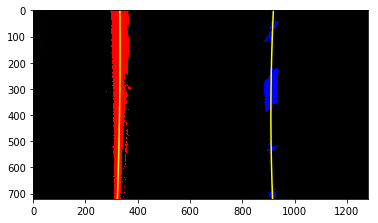

In [10]:
leftx, lefty, rightx, righty = find_lane_pixels_raw(binary_warped)
left_fit, right_fit = fit_polynomial(leftx, lefty, 
                                     rightx, righty)
left_fitx, right_fitx, ploty = generate_lines(left_fit, right_fit, 
                                              binary_warped.shape[0])
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

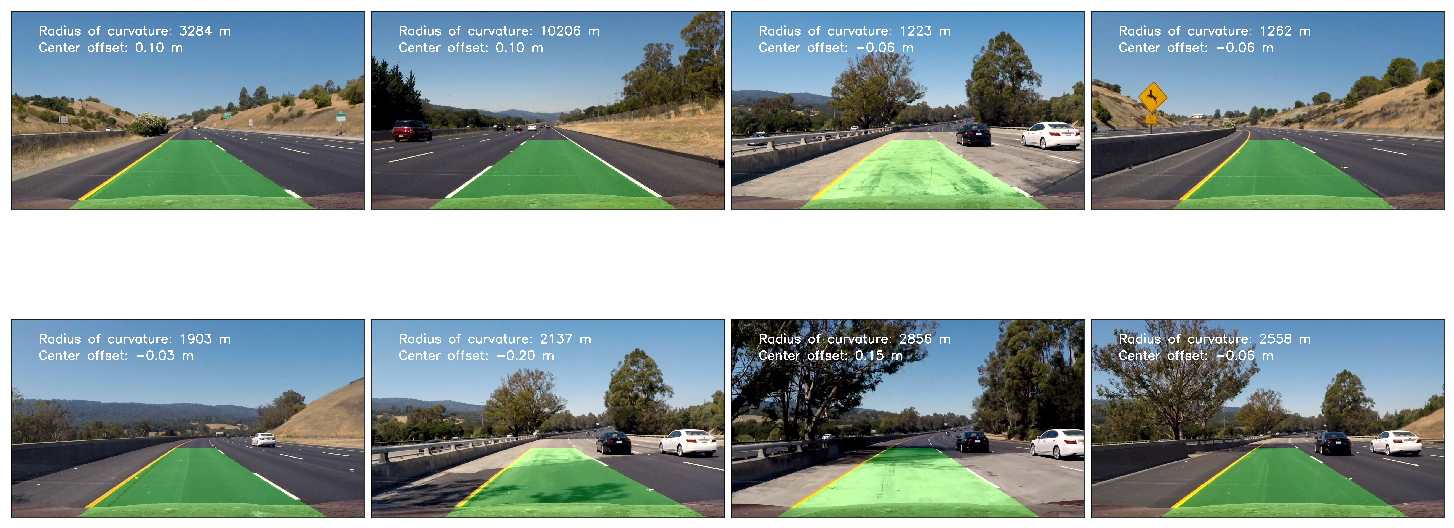

In [11]:
def process_images():
    test_images = read_images(TEST_IMAGE_DIRECTORY)
    marked_images = {}
    for fname, img in test_images.items():
        marked_images[fname] = find_lane_lines_in_image(img)
    return marked_images

marked_images = process_images()
save_images(marked_images, os.path.join(OUTPUT_DIR, 'images_marked.jpg'))

In [12]:
TEST_VIDEO_DIRECTORY = 'test_videos'

def process_videos():
    test_videos = read_videos(TEST_VIDEO_DIRECTORY)
    for fname, video in test_videos.items():
        marked_video = video.fl_image(find_lane_lines_in_video)
        marked_video.write_videofile(os.path.join('output_videos', fname),
                                     audio=False)
    
process_videos()

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [06:14<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [06:47<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [02:19<00:00,  3.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

